In [1]:
from data.dataset import DatasetSimulationData
from data.dataloader import DataLoader
from data.transforms import NormalizeTransform, ComposeTransform, ReduceTo2DTransform, PowerOfTwoTransform, ToTensorTransform
from visualization.visualize_data import plot_datapoint
from data.utils import save_pickle
from networks.unet_leiterrl import TurbNetG, UNet, weights_init

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
from tqdm.auto import tqdm
from torchvision.utils import make_grid

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

from networks.unet_leiterrl import weights_init

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from visualization.visualize_data import plot_data_inner


In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
# TODO not necessary to cut of edges - exponential behaviour at edges ?! fix it otherwise!
#transforms = ComposeTransform([NormalizeTransform(), CutOffEdgesTransform()])

# DATASET = GWF_HP_Dataset(dataset_name ="dataset_HDF5_testtest", transform = NormalizeTransform(), 
#                  input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]", 
#                  "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
#                  output_vars=["Liquid_Pressure [Pa]", "Temperature [C]"])
# DATALOADER = DataLoader(DATASET, batch_size=2, shuffle=True, drop_last=False)
# 
# print(f"Dataset size: {len(DATASET)}")
# print(f"Dataloader size: {len(DATALOADER)}")
# 
# save_pickle({"dataset": DATASET, "dataloader" : DATALOADER}, "dataset_HDF5_testtest_and_dataloader.p")
# 
# DATASET[0]['x'][0,:,:,:].shape
# plot_datapoint(DATASET, run_id=1, view="side_hp")

# Splitting Data

In [5]:
# # split dataset into train, val, test
# datasets = {}
# for mode in ['train', 'val', 'test']:
#     temp_dataset = GWF_HP_Dataset(
#         dataset_name ="dataset_HDF5_testtest", transform = NormalizeTransform(), 
#         input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]", 
#         "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
#         output_vars=["Liquid_Pressure [Pa]", "Temperature [C]"],
#         mode=mode, split={'train': 0.6, 'val': 0.2, 'test': 0.2}
#     )
#     datasets[mode] = temp_dataset
# 
# # Create a dataloader for each split.
# dataloaders = {}
# for mode in ['train', 'val', 'test']:
#     temp_dataloader = DataLoader(
#         dataset=datasets[mode],
#         batch_size=2,
#         shuffle=True,
#         drop_last=False,
#     )
#     dataloaders[mode] = temp_dataloader

## test splitting data

In [6]:
# print(datasets["train"].runs)
# print(datasets["train"][0].keys())
# print(len(dataloaders["train"]))
# 
# for batch in dataloaders["train"]:
#     print(batch['x'].shape)
#     print(batch['y'].shape)
#     break

# test TurbNetG (from Rapha, from somebody else) 2D testcase on my data

In [10]:
from torch.nn import MSELoss

import learn_process as lp
from networks.unet_leiterrl import TurbNetG, UNet
from networks.dummy_network import DummyNet


# parameters of model and training
loss_fn = MSELoss()
n_epochs = 1 #60000
lr=0.0004 #0.0004

#model = TurbNetG(channelExponent=4, in_channels=4, out_channels=2)
unet_model = UNet(in_channels=5, out_channels=1).float()
# TODO too many in channels for unet?
fc_model = DummyNet().float()
# model.to(device)

# init data
datasets_2D, dataloaders_2D = lp.init_data(reduce_to_2D=True, overfit=True)
# train model
lp.train_model(unet_model, dataloaders_2D, loss_fn, n_epochs, lr)

epochs:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 5, 3, 3], expected input[1, 20, 150, 16] to have 5 channels, but got 20 channels instead

## test visualization and normalization and reverse of data

In [3]:
# create and directly split dataset into train, val, test
def init_data(reduce_to_2D = True, overfit = False, normalize=True, dataset_name="approach2_dataset_generation_simplified/dataset_HDF5_testtest", batch_size=100, not_transform=False):
    """
    Initialize dataset and dataloader for training.

    Parameters
    ----------
    reduce_to_2D : bool
        If true, reduce the dataset to 2D instead of 3D
    overfit : bool
        If true, only use a small subset of the dataset for training, achieved by cheating: changing the split ratio
    normalize : bool
        If true, normalize the dataset, usually the case; not true for testing input data magnitudes etc 
    dataset_name : str
        Name of the dataset to use (has to be the same as in the folder)
    batch_size : int
        Size of the batch to use for training
    
    Returns
    -------
    datasets : dict
        Dictionary of datasets, with keys "train", "val", "test"
    dataloaders : dict
        Dictionary of dataloaders, with keys "train", "val", "test"
    """
    
    datasets = {}
    transforms_list = [ToTensorTransform(), PowerOfTwoTransform(oriented="left")]
    if normalize:
        transforms_list.append(NormalizeTransform())
    if reduce_to_2D:
        transforms_list.append(ReduceTo2DTransform())

    transforms = ComposeTransform(transforms_list)

    if not_transform:
        transforms = None

    split = {'train': 0.6, 'val': 0.2, 'test': 0.2} if not overfit else {'train': 0.2, 'val': 0.2, 'test': 0.6}
    
    for mode in ['train', 'val', 'test']:
        temp_dataset = DatasetSimulationData(
            dataset_name=dataset_name, transform=transforms,
            input_vars=["Liquid Y-Velocity [m_per_y]", "Liquid Z-Velocity [m_per_y]",  #"Liquid X-Velocity [m_per_y]",
            "Liquid_Pressure [Pa]", "Material_ID", "Temperature [C]"],
            output_vars=["Temperature [C]"], #. "Liquid_Pressure [Pa]"
            mode=mode, split=split
        )
        datasets[mode] = temp_dataset


    # Create a dataloader for each split.
    dataloaders = {}
    for mode in ['train', 'val', 'test']:
        temp_dataloader = DataLoader(
            dataset=datasets[mode],
            batch_size=batch_size,
            shuffle=True,
            drop_last=False,
        )
        dataloaders[mode] = temp_dataloader

    # # Assert if data is not 2D
    # def assertion_error_2d(datasets):
    #     for dataset in datasets["train"]:
    #         shape_data = len(dataset['x'].shape)
    #         break
    #     assert shape_data == 3, "Data is not 2D"
    # 
    # assertion_error_2d(datasets)

    return datasets, dataloaders

def train_model(model, dataloaders, loss_fn, n_epochs, lr):
    """
    Train the model for a certain number of epochs.
        
    Parameters
    ----------
    model : torch.nn.Module
        Choose the model to train with varying structure etc
    dataloaders : dict
        Dictionary of dataloaders, with keys "train", "val", "test"
    loss_fn : torch.nn.Module
        Loss function to use, e.g. MSELoss() - depends on the model
    n_epochs : int
        Number of epochs to train for
    lr : float
        Learning rate to use
    """

    # initialize Adam optimizer
    optimizer = Adam(model.parameters(), lr=lr) 
    # initialize tensorboard
    writer = SummaryWriter()
    loss_hist = []
    
    model.apply(weights_init)
    epochs = tqdm(range(n_epochs), desc = "epochs")
    for epoch in epochs:
        for batch_idx, data_point in enumerate(dataloaders["train"]):
            # datasets["train"] contains 3 data points
            x = data_point["x"].float()
            y = data_point["y"].float()

            model.zero_grad()
            optimizer.zero_grad()

            y_out = model(x) # dimensions: (batch-datapoint_id, channel, x, y)
            mse_loss = loss_fn(y_out, y)
            loss = mse_loss
            
            loss.backward()
            optimizer.step()
            epochs.set_postfix_str(f"loss: {loss.item():.4f}")

            loss_hist.append(loss.item())
            writer.add_scalar("loss", loss.item(), epoch*len(dataloaders["train"])+batch_idx)
            writer.add_image("y_out_0", y_out[0,0,:,:], dataformats="WH", global_step=epoch*len(dataloaders["train"])+batch_idx)
            #writer.add_image("y_out_1", y_out[0,1,:,:], dataformats="WH")

        writer.add_image("x_0", x[0,0,:,:], dataformats="WH")
        # writer.add_image("x_1", x[0,1,:,:], dataformats="WH")
        # writer.add_image("x_2", x[0,2,:,:], dataformats="WH")
        # writer.add_image("x_3", x[0,3,:,:], dataformats="WH")
        # writer.add_image("x_4", x[0,4,:,:], dataformats="WH")
        # writer.add_image("y_0", y[0,0,:,:], dataformats="WH")
        # #writer.add_image("y_1", y[0,1,:,:], dataformats="WH")

    #writer.add_graph(model, x)
    print('Finished Training')

# Test BCs

RUN_0_current_winner
Resulting picture is at visualization/pics/plot_phys_props_RUN_42_VIEW_side_hp.jpg


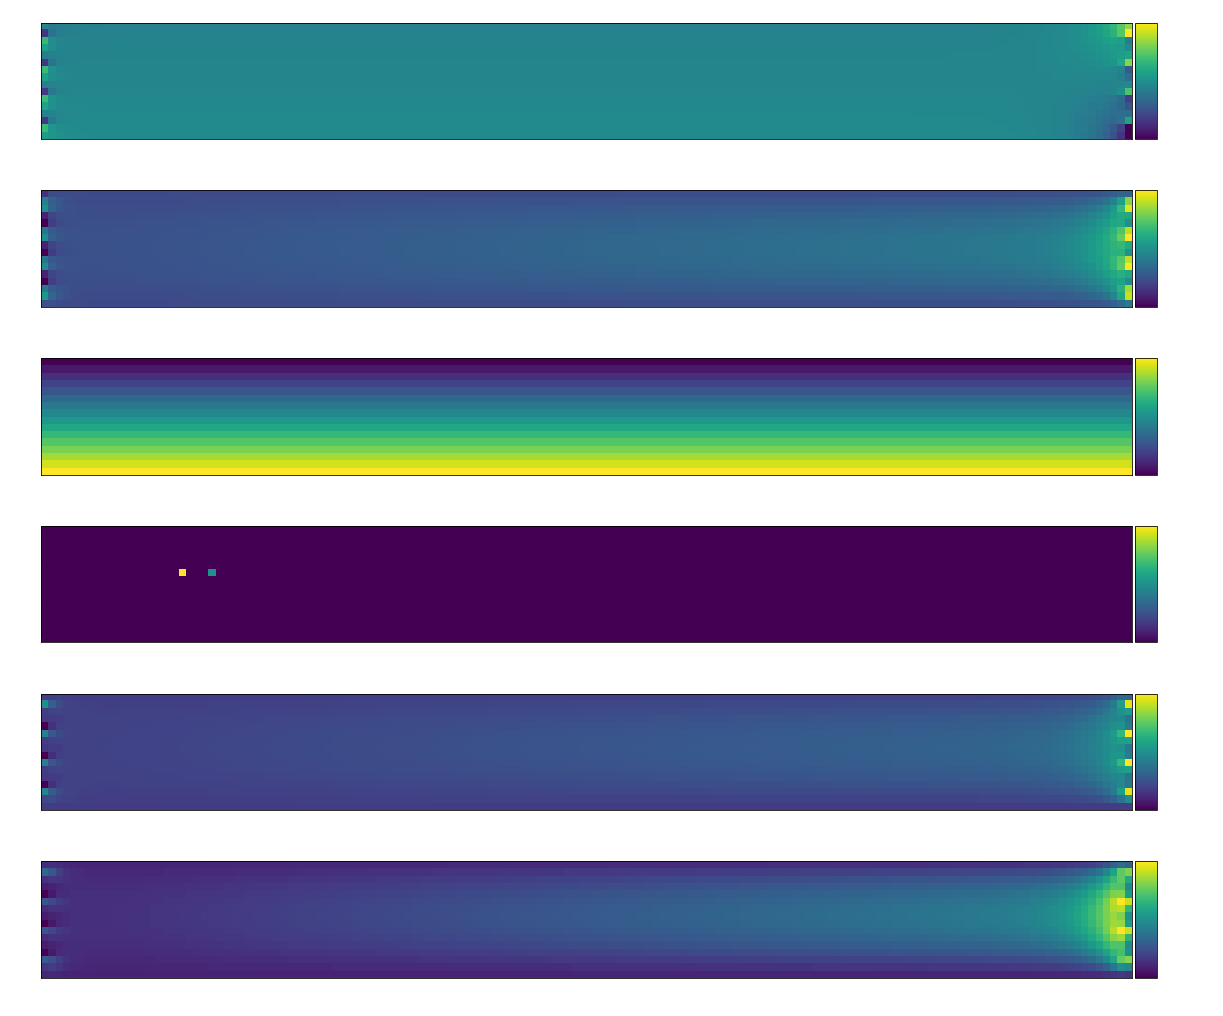

In [12]:
counter = 1
if counter != 0:
    import learn_process as lp
    datasets_gt, _ = lp.init_data(reduce_to_2D=False, overfit=False, just_plotting=True, dataset_name="groundtruth_hps_no_hps/groundtruth_hps_overfit_01")

    for mode in datasets_gt:
        i = 0
        for run in datasets_gt[mode]:
            print(mode, i, ": ", run["run_id"])
            i += 1
    counter = 0
else:
    tensor_dict = datasets_gt["train"][0]
    print(tensor_dict["run_id"])

    prop_in = datasets_gt["train"].get_input_properties()
    prop_out = datasets_gt["train"].get_output_properties()
    plot_data_inner(tensor_dict, prop_in, prop_out, view="side_hp", oriented="left")

    # compare pressure gradient and temperature values by common sense
    pressure = tensor_dict["x"][2,:,:,:]
    print(f"pressure at top: {pressure[0,0,15]}")
    print(f"pressure diff in z direction: {(pressure[0,0,14] - pressure[0,0,15]):.2f} [Pa]")
    print(f"pressure diff in y direction: {(pressure[0,1,15] - pressure[0,0,15]):.2f} [Pa]")
    print(f"pressure diff in x direction: {(pressure[1,0,15] - pressure[0,0,15]):.2f} [Pa]")

    temperature = tensor_dict["x"][4,:,:,:]
    print(f"max and min temp at first timestep: {np.max(temperature):.2f}, {np.min(temperature):.2f} [C]")
    temperature_final = tensor_dict["y"][0,:,:,:]
    print(f"max and min temp at last timestep: {np.max(temperature_final):.2f}, {np.min(temperature_final):.2f} [C]")

init done [total number of datapoints/runs: 2]
no transforms applied:  'NoneType' object is not callable


TypeError: 'DataPoint' object is not subscriptable

In [10]:
# test the reversing of the normalization, if correct, should result in the same pics as the cell above
datasets, dataloaders = init_data(reduce_to_2D=False, overfit=True, dataset_name="groundtruth_hps_no_hps/groundtruth_no_hps")
tensor_dict = datasets["train"][0]
# tensor_reversed_norm = datasets["train"].reverse_transform(0, tensor_dict["x_mean"], tensor_dict["x_std"], tensor_dict["y_mean"], tensor_dict["y_std"])

prop_in = datasets["train"].get_input_properties()
prop_out = datasets["train"].get_output_properties()

print(datasets["train"][0]["x"].shape)

# plot_data_inner(tensor_reversed_norm, prop_in, prop_out, view="top", oriented="left")
plot_data_inner(datasets["train"][0], prop_in, prop_out, view="top", oriented="left")


TypeError: __init__() got an unexpected keyword argument 'input_vars'